# Win/weapon: WM 2023-03-05

## Parameters

In [2]:
from s2_analytics.constants import WEAPON_MODS_DATES, WEAPON_MODS_CATALOG
import datetime
ACTIVE_WM = WEAPON_MODS_CATALOG.previous()
CHART_MAX_WIDTH = 10
CHART_HEIGHT_PER_ENTRY = 0.3

MINIMUM_SAMPLES =20
MAX_IMBALANCE = 0.20
START_DATE = ACTIVE_WM.datetime
END_DATE = WEAPON_MODS_CATALOG.latest().datetime
PLAYLISTS = ["CTF-Standard-6"]

print(f"Start date: {START_DATE}")
print(f"End date: {END_DATE}")
print(f"Playlists: {','.join(PLAYLISTS)}")
print()
print(f"Min samples: {MINIMUM_SAMPLES}")
print(f"Max match imbalance: {MAX_IMBALANCE * 100:.0f}% \n"
      f"    (eg worst balance: Red team win probability {(50 - MAX_IMBALANCE * 100 / 2):.1f}% and {(50 + MAX_IMBALANCE * 100 / 2):.1f}% for Blue)")


Start date: 2023-03-05 00:00:00
End date: 2023-03-20 00:00:00
Playlists: CTF-Standard-6

Min samples: 20
Max match imbalance: 20% 
    (eg worst balance: Red team win probability 40.0% and 60.0% for Blue)


In [3]:
from s2_analytics.collect.summary_collector import SummaryCollector
from s2_analytics.collect.team_round_tag_collector import TeamRoundTagCorrelationAnalyzer
from pandas import DataFrame

from s2_analytics.filters import max_imbalance
import sqlite3

import pandas as pd
import seaborn as sns

from s2_analytics.collect.sqlite_collector import SqliteCollector
from s2_analytics.constants import WEAPONS_PRIMARY
from s2_analytics.importer import import_games
from s2_analytics.analyze.main_weapon_analyzer import MainWeaponRoundTagger

conn = sqlite3.connect("file::memory:")
sqlite_collector = SqliteCollector(sqlite_conn=conn).init()
summary_collector = SummaryCollector(conn, sqlite_collector)
tag_correlation_analyzer = TeamRoundTagCorrelationAnalyzer(conn, sqlite_collector, [
    MainWeaponRoundTagger([WEAPONS_PRIMARY])]).init()
import_games(
    "logs_ranked/",
    start_date=START_DATE,
    end_date=END_DATE,
    processors=[tag_correlation_analyzer, sqlite_collector],
    game_filters=[
        lambda g: g.playlist_code in ["CTF-Standard-6"],
        max_imbalance(MAX_IMBALANCE)
    ]
)
pass

## Data summary

In [4]:
import tabulate

summary = summary_collector.get_summary().to_table()
tabulate.tabulate(summary, tablefmt='html')

First game,2023-03-05
Last game,2023-03-19
Games total,132
Rounds total,324
Games in playlist `CTF-Standard-6`,132


## Aggregated result

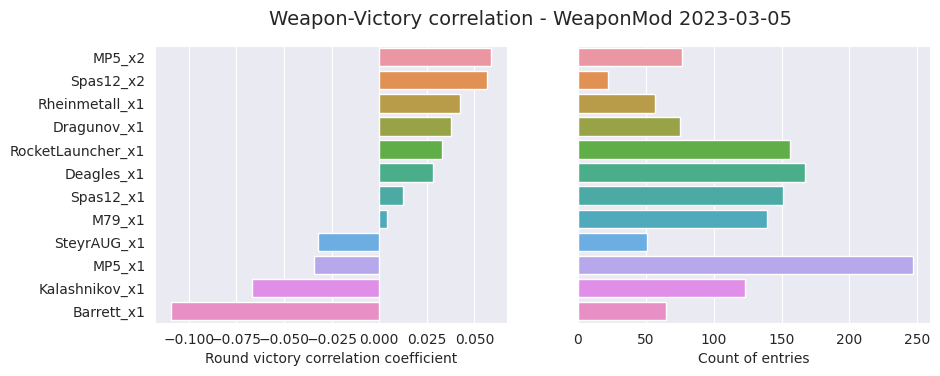

In [5]:
from matplotlib import pyplot as plt

correlation_per_map = tag_correlation_analyzer.calculate_win_correlation()

correlation_df = pd.DataFrame(correlation_per_map.items(), columns=["tag", "corr"])
counts_df = pd.DataFrame(
    tag_correlation_analyzer.tag_counts().items(),
    columns=["tag", "cnt"])

df = pd.merge(correlation_df, counts_df, on=["tag"])


def filter_and_sort_for_corr_charts(df: DataFrame, min_samples):
    df["corr_abs"] = df['corr'].abs()
    df = df[df.apply(lambda x: x["cnt"] > min_samples, axis=1)]
    return df.sort_values("corr_abs", ascending=False) \
        .sort_values("corr", ascending=False)


df = filter_and_sort_for_corr_charts(df, MINIMUM_SAMPLES)

fig, axes = plt.subplots(1, 2, figsize=(CHART_MAX_WIDTH, len(df["corr"]) * CHART_HEIGHT_PER_ENTRY), sharey=True)
fig.suptitle(f"Weapon-Victory correlation - {ACTIVE_WM}", fontsize=14)
sns.barplot(x=df["corr"], y=df["tag"], ax=axes[0]) \
    .set(xlabel="Round victory correlation coefficient", ylabel=None)
sns.barplot(x=df["cnt"], y=df["tag"], ax=axes[1]) \
    .set(xlabel="Count of entries", ylabel=None)
pass

## WeaponMod changes

In [6]:
from IPython.display import display, Markdown
display(Markdown(f"""
Full change set:

- [{ACTIVE_WM.changes_url}]({ACTIVE_WM.changes_url})

Summary:

{ACTIVE_WM.changes}
"""))


Full change set:
- [https://www.diffchecker.com/6mF7J5Ic/](https://www.diffchecker.com/6mF7J5Ic/)

Summary:

- Dragunov
    - faster interval (0.7s -> 0.67s)
    - Clip increased (6 -> 7)
    - Reloadtime decreased (2.7s -> 2.5s)
    - 15% more head damage
    - 12% more leg damage
    - better accuracy & less movement inaccuracy 

- Spas-12
    - less self-boost
    - faster reload (0.45s -> 0.4s)

- M79
    - boost forces decreased
    - less splash damage
    - slightly more reloadtime (2.9s -> 3.0s)

- RPG
    - boost forces decreased

- Kalashnikov & Steyr-AUG
    - more bullet penetration

- MP5
    - slightly less head damage
    - slightly less leg damage
    - ReloadTime increased (1.9s -> 2.0s)

- Barret
    - no longer 'autoreloads' when not equipped

- Makarov
    - slightly lower reloadtime (1.4s -> 1.3s)

- Knife
    - no random kills from nearby explosions

- Minigun
    - clip increased (90 -> 100)

- Flag forces
    various improvements
    
